#### Import the needed libraries

In [13]:
from abc import abstractmethod
import matplotlib.pyplot as plt
import numpy as np
from numpy import polyfit, poly1d
from termcolor import colored
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Ridge
import fbprophet

#### Load data and Preprocessing

In [14]:
def data_preprocessing(input_name: str, output_name: str):
    print(colored("LOADED FILE " + input_name[5:7] + " !!!", 'blue'))
    data = pd.read_csv(input_name, sep="\t")
    data.index = range(data.shape[0])
    data.columns = ["y"]
    data["x"] = range(data.shape[0])

    # position of the missing prices
    pos_missing = data.y.str.startswith("Missing")

    data_missing = data[pos_missing]

    # training data set
    data_training = data[pos_missing == False]

    actual_prices = pd.read_csv(output_name, header=None)

    data_training = data_training.astype("float")
    actual_prices = actual_prices.astype("float")

    return data_training.x, data_training.y, data_missing.x, actual_prices

#### Build Custom Estimators for Grid Search Cross-Validation

In [15]:
class BaseCustomEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, param1=None, param2=None, param3=None):
        """
        :param (param1, param2, param2): are hyperparameters -
                there values depend on the underlying model. The default value is 0.05.
        """
        self.param1 = param1
        self.param2 = param2
        self.param3 = param3

    @abstractmethod
    def fit(self):
        raise NotImplementedError("abstractmethod fit is yet to be implemented")

    def predict(self, X):
        is_trained = getattr(self, "trained_model", False)
        if is_trained:
            return self.trained_model(X)
        else:
            raise RuntimeError("the model has not been trained; call fit.")


class SplineEstimator(BaseCustomEstimator):
    def __init__(self, param1=None, param2=None):
        """
        :param param1: degree_spline(int) - Degree of the smoothing spline. Must be <= 5.
                        Default is k=3, a cubic spline.
        :param param2: smoothing_factor(float) - Smoothing factor used to choose the
                        no. of knots. No. of knots will be increased until the smoothing
                        condition is satisfied.
        """
        super().__init__(param1, param2)

    def fit(self, X, y):
        self.trained_model = UnivariateSpline(X, y, k=self.param1, s=self.param2)
        return self


class PolyInterpEstimator(BaseCustomEstimator):
    def __init__(self, param1=None):
        """
        :param param1: degree(int) - degree of the polynomial
        """
        super().__init__(param1)

    def fit(self, X, y):
        self.trained_model = poly1d(polyfit(X, y, deg=self.param1))
        return self


class FBProphetEstimator(BaseCustomEstimator):
    def __init__(self, param1=None):
        """
        :param param1: changepoint_prior_scale(int) - 
                        for controlling how sensitive the trend is to changes
        """
        super().__init__(param1)

    def fit(self, X_y, y):
        model = fbprophet.Prophet(
            changepoint_prior_scale=self.param1, 
            yearly_seasonality=True, 
            weekly_seasonality=True,
            daily_seasonality=True
        )
        self.trained_model = model.fit(df=X_y)
        return self

    def predict(self, X):
        is_trained = getattr(self, "trained_model", False)
        if is_trained:
            X = pd.DataFrame({"ds": X.ds})
            return self.trained_model.predict(X).yhat
        else:
            raise RuntimeError("the model has not been trained; call fit.")

#### Utility Objects

In [16]:
ACTUAL_COLOR = "navy"
PREDICTED_COLOR = "firebrick"
MERIC_SCORING = "neg_mean_absolute_error"
CV = 10

def plot_actual_predicted(X, y_actual, y_pred):
    """
    :param X: List, Array or Series signifying the x-axis
    :param y_actual: List, Array or Series of the actual
    :param y_pred: List, Array or Series of the predicted
    :return: Renders a plot.
    """
    plt.figure(figsize=(15, 5))
    plt.scatter(
        X, y_actual, marker="o", label="Actual Price", color=ACTUAL_COLOR, s=30
    )
    plt.plot(X, y_pred, "g-", lw=2.5, label="Fitted Curve", color=PREDICTED_COLOR)
    plt.title("Plot of Actual Points vs. Fitted Curve")
    plt.xlabel("Ordered Period (x)")
    plt.ylabel("Stock Prices (y)")
    plt.legend(loc="upper left")
    plt.show()
    
    
def visualization_dist(x_test, y_test, y_pred):
    x_test = x_test.tolist()
    y_test = y_test.iloc[:, 0].tolist()
    
    plt.figure(figsize=(15, 5))
    plt.scatter(
        x_test, y_test, marker="o", label="Actual Price", color=ACTUAL_COLOR, s=30
    )
    plt.scatter(
        x_test, y_pred, marker="o", label="Predicted Price", color=PREDICTED_COLOR
    )
    plt.title(
        "Viewing the closeness of Actual vs. Predicting values of the Missing Stock Prices"
    )
    for i in range(1, len(x_test)+1):
        plt.annotate(i, (x_test[i - 1], y_test[i - 1]), fontsize=15, color=ACTUAL_COLOR)
        plt.annotate(i, (x_test[i - 1], y_pred[i - 1]), fontsize=8)
        
    plt.xlabel("Ordered Period (x)")
    plt.ylabel("Stock Prices (y)")
    plt.legend(loc="lower left")
    plt.show()    

# Model Evaluation Metric:

Mean absolute error will be used to evaluate the models in this project.

# <u> Working With Dataset

#### Specify the data to be loaded
- Change the input data to work through other a specific file.

In [17]:
input_file = "input00.txt"
output_file = "output00.txt"

In [18]:
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = data_preprocessing(input_file, output_file)

LOADED FILE 00 !!!


In [19]:
model_eval_df = pd.DataFrame(columns = ['model', 'optimal_param', 'testing_MAE'], index=range(4))

# <u>1. Model: Spline Interpolation
This uses low-degree polynomials, and selects polynomial pieces in order to optimally fit the data.
Univariate-Spline: It's a form of spline involving one variable.

### (1a) Fitting the model with optimal Hyperparamters via Grid Search with 10-folds CV

In [20]:
degree_splines = [2, 3, 4, 5]
smoothing_factors = np.arange(3, 13, 0.5)

param_tune_sp = {"param1": degree_splines, "param2": smoothing_factors}
spline = GridSearchCV(
    SplineEstimator(), param_tune_sp, cv=CV, scoring=MERIC_SCORING
)

spline.fit(X_TRAIN, Y_TRAIN)

GridSearchCV(cv=10, error_score='raise',
       estimator=SplineEstimator(param1=None, param2=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'param1': [2, 3, 4, 5], 'param2': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
        8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

### (1b) The optimal hyperparameters are:

In [21]:
model_eval_df.optimal_param[0] = 'deg spline = {} and smooth factor = {}'.format(*spline.best_params_.values())
print(" - degree of splines = {} \n - smoothing factors = {}".format(*spline.best_params_.values()))

 - degree of splines = 2 
 - smoothing factors = 9.5


### (1c) Visualizing the best fitted model

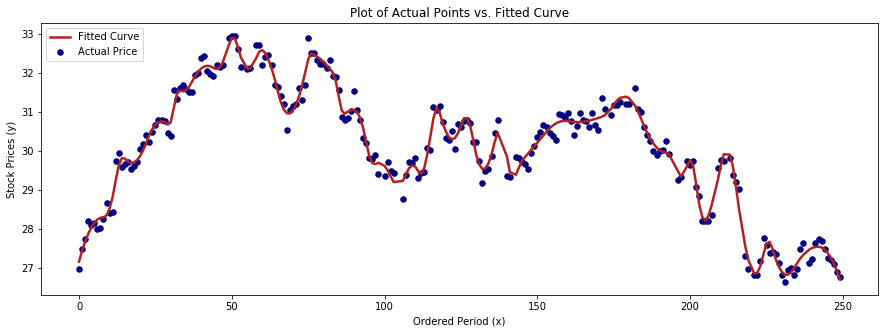

In [22]:
plot_actual_predicted(X_TRAIN, Y_TRAIN, spline.predict(X_TRAIN))

### (1d) Testing

In [23]:
sp_test_pred_y = spline.predict(X_TEST)
test_spline_err = metrics.mean_absolute_error(Y_TEST, sp_test_pred_y)
model_eval_df.model[0] = 'Spline Interpolation'
model_eval_df.testing_MAE[0] = round(test_spline_err, 6)
print("Testing MAE = {}".format(round(test_spline_err, 6)))

Testing MAE = 0.27821


### (1e) Further Visualization

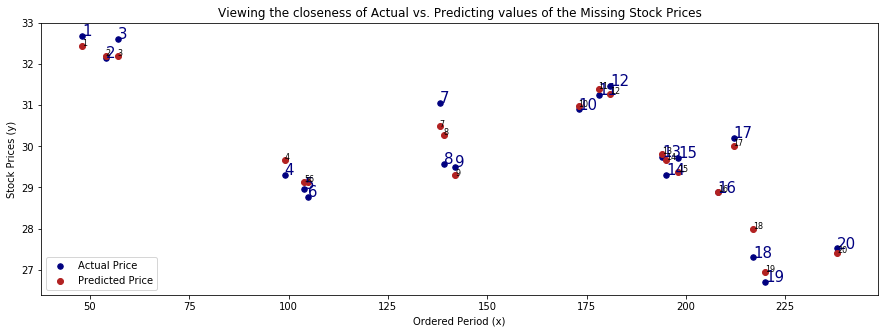

In [24]:
visualization_dist(X_TEST, Y_TEST, sp_test_pred_y)

# <u>2. Model: Polynomial Interpolation
This is a generalization of linear interpolation where a polynomial function is used in connecting the points.

### (2a) Fitting the model with optimal Hyperparamters via Grid Search with 10-folds CV